# Notebook to test [SFCN model](https://github.com/ha-ha-ha-han/UKBiobank_deep_pretrain) for brain age prediction

## Currently using a sample ukbb subject 

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
from models.sfcn import *
from models import dp_loss as dpl
from models import dp_utils as dpu

import nibabel as nib

import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt

## Paths

In [2]:
data_dir = "/home/nikhil/projects/brain_changes/data/ukbb/"
    
# This is to be modified with the path of saved weights
p_ = 'models/run_20190719_00_epoch_best_mae.p'

## Load Model

In [3]:
model = SFCN()
model = torch.nn.DataParallel(model)

if torch.cuda.is_available():
    map_location=lambda storage, loc: storage.cuda()
else:
    map_location='cpu'
    
model.load_state_dict(torch.load(p_, map_location=torch.device('cpu')))
# checkpoint = torch.load(p_, map_location=map_location)

<All keys matched successfully>

## Load sample data
### Either random or UKBB sample subject

### eid	sex	birth_year	T1-ses2	T1-ses3	ethnicity	age_at_ses2	age_at_ses3	age_at_recruitment
								
- 1004084	1.0	1947.0	20252_2_0	20252_3_0	1001.0	70.0	72.0	60.0
- 1010063	0.0	1964.0	20252_2_0	20252_3_0	1001.0	53.0	55.0	45.



In [4]:
use_random_scan = False
subject_age_dict = {"sub-1010063": 53, 
                    "sub-1004084": 70}


if use_random_scan: 
    print("Generating a random scan...")
    data = np.ones([182, 218, 182]).astype(np.float)
    #data = np.random.rand(182, 218, 182)
    label = np.array([71.3,]) # Assuming the random subject is 71.3-year-old.

else:
    # Sample subject needs to be in the MNI space
    subject_id = "sub-1004084" #"sub-1010063" #"sub-1004084"
    scan_session = "ses-2"

    print(f"Using a sample scan from ukbb: {subject_id}")
    subject_dir = f"{data_dir}imaging/ukbb_test_subject/{subject_id}/{scan_session}/non-bids/T1/"
    T1_mni = f"{subject_dir}T1_brain_to_MNI.nii.gz"

    ukbb_follow_up_csv = f"{data_dir}tabular/tab_follow_up.csv"
    ukbb_metadata = pd.read_csv(ukbb_follow_up_csv)

    data = nib.load(T1_mni).get_fdata()
    print(f"image shape: {data.shape}")
    print(f"image mean: {np.mean(data.ravel())}")

    # Age at scanning
    age = subject_age_dict[subject_id]
    label = np.array([age,])


# Transforming the age to soft label (probability distribution)
# bin_range = [42,82]
bin_range = [50,90]
bin_step = 1
sigma = 1
y, bc = dpu.num2vect(label, bin_range, bin_step, sigma)
y = torch.tensor(y, dtype=torch.float32)
print(f'Label shape: {y.shape}')

Using a sample scan from ukbb: sub-1004084
image shape: (182, 218, 182)
image mean: 225.7059078259174
Label shape: torch.Size([1, 40])


In [5]:
save_cropped_img = False

# Preprocessing
data = data/data.mean()
data = dpu.crop_center(data, (160, 192, 160))

if save_cropped_img:
    affine = nib.load(T1_mni).affine
    cropped_T1 = nib.Nifti1Image(np.squeeze(data), affine)
    save_path = f'{subject_dir}cropped_image.nii'
    nib.save(cropped_T1, save_path)
    print(f"Saving cropped image here: {save_path}")

# Move the data from numpy to torch tensor on GPU
sp = (1,1)+data.shape
data = data.reshape(sp)
input_data = torch.tensor(data, dtype=torch.float32)
print(f'Input data shape: {input_data.shape}')
print(f'dtype: {input_data.dtype}')

# Evaluation
model.eval() # Don't forget this. BatchNorm will be affected if not in eval mode.
with torch.no_grad():
    output = model.module(input_data)

# Output, loss, visualisation
x = output[0].reshape([1, -1])
print(f'Output shape: {x.shape}')
loss = dpl.my_KLDivLoss(x, y).numpy()

# Prediction, Visualisation and Summary
x = x.numpy().reshape(-1)
y = y.numpy().reshape(-1)

prob = np.exp(x)
pred = prob@bc
print(f"pred: {pred}, label = {label}")

Input data shape: torch.Size([1, 1, 160, 192, 160])
dtype: torch.float32
Output shape: torch.Size([1, 40])
pred: 74.83462088598753, label = [70]


## Plots

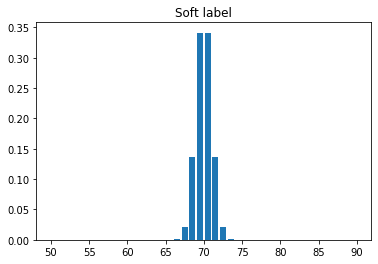

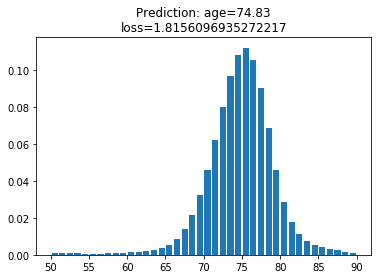

In [7]:
plt.bar(bc, y)
plt.title('Soft label')
plt.show()

plt.bar(bc, prob)
plt.title(f'Prediction: age={pred:.2f}\nloss={loss}')
plt.show()